# Feature Engineering:

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

%matplotlib inline
#sns.set_theme(style="whitegrid")
sns.set_palette('rainbow')

We Import our cleaned dataset and export a feature-engineered data set, so we can keep track of the effects our feature engineering had on our models:

In [6]:
df = pd.read_csv("00_data/f_chtr_churn_traintable_nf.csv", index_col=0)

ZON - Features: we create dummies out of the 14 ZON features with 3 categories,
we also add 1 aggregation function as most of the columns have >99% zeros:

In [7]:
def todumm(cat):
    if cat >1: 
        return 1
    else:
        return 0

### ZON - Features

In [8]:
for i in df.iloc[: ,21:35]:
    df[i] = df[i].apply(todumm)
    
agg_zon = df.iloc[: ,21:35].sum(axis=1) # this aggregation function should be 

In [11]:
agg_zon.value_counts()

0    188140
1     20580
2       323
dtype: int64

9.63% of the cleaned sample registered to a ZON-Service first time.
Only a fraction of the cleaned sample (0.07% or 122) registered to 2 ZON-Services for the first time, which should not be possible by default

In [13]:
agg_zon = agg_zon.to_frame(name="agg_zon")

AttributeError: 'DataFrame' object has no attribute 'to_frame'

In [16]:
df_doubles = df.join(agg_zon)

#### Error Analysis on Zon-Features:

In [17]:
df_doubles = df_doubles.query("agg_zon == 2").iloc[: , 21:35]
df_doubles.head(1)

,zon_che_opt_in,zon_sit_opt_in,zon_zp_grey,zon_premium,zon_boa,zon_kommentar,zon_sonstige,zon_zp_red,zon_rawr,zon_community,zon_app_sonstige,zon_schach,zon_blog_kommentare,zon_quiz


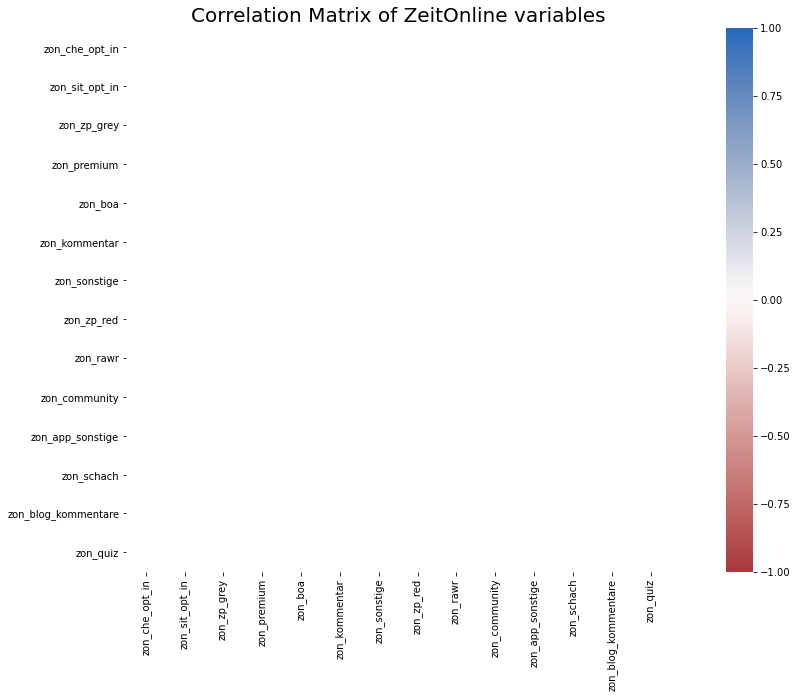

In [18]:
corr = df_doubles.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#cmap = sns.diverging_palette(220, 10, as_cmap=True) (diverging not necessary)
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr, mask=mask,square=True, linewidths=.5, annot=True, vmin=-1, vmax=1, center= 0, fmt='.2f' , cmap="vlag_r")
plt.yticks(rotation=0)
plt.title('Correlation Matrix of ZeitOnline variables', fontsize=20)
plt.show()

- There should not be any correlations 'cause all the features are on "first time registration"
- check for highest correlation(0.44) between 'zon sonstige' & 'zon premium':

In [10]:
df_doubles.sort_values(['zon_premium','zon_sonstige'], ascending=[False,False]).head(50)

,zon_che_opt_in,zon_sit_opt_in,zon_zp_grey,zon_premium,zon_boa,zon_kommentar,zon_sonstige,zon_zp_red,zon_rawr,zon_community,zon_app_sonstige,zon_schach,zon_blog_kommentare,zon_quiz


In [ ]:
df.query('zon_premium == 1 & zon_sonstige ==1')

- 14 people who registered to a ZON-Service registered the first time on ZON-Premium & on ZON-sonstige
- they do not have any other similarities, there are no patterns, why this happens
- this is the result of a bad data-architecture and wrongly assigned clusters 

### NL-Features
0 Nicht vorhanden, 
1: Abgemeldet, 
2: Aktiv

We also transform those to dummies, like we already did with nl_blacklist_sum, nl_bounced_sum, nl_sperrliste_sum, nl_opt_in_sum in outlier handling:

In [ ]:
df.iloc[: , lambda df: [41,42,43,44,45,46,49,50]].head(1)

In [ ]:
for i in df.iloc[: , lambda df: [41,42,43,44,45,46,49,50]]:
    df[i] = df[i].apply(todumm)
    
# agg_nl = df.iloc[: , lambda df: [41,42,43,44,45,46,47,49,50]].sum(axis=1) not necessary, we have nl_aktivität as counbt for ALL Newsletters

### Zeitreihen:

Fill missing Values (in Final_EDA needs to be added at the top):

In [ ]:
df.kuendigungs_eingangs_datum.fillna(value='2020-05-26', inplace=True)

Convert object-columns to datetime 

In [ ]:
df['liefer_beginn_evt']= pd.to_datetime(df['liefer_beginn_evt'])

In [ ]:
df['kuendigungs_eingangs_datum']= pd.to_datetime(df['kuendigungs_eingangs_datum'])

In [ ]:
df['abo_registrierung_min']= pd.to_datetime(df['abo_registrierung_min'])

In [ ]:
df['nl_registrierung_min']= pd.to_datetime(df['nl_registrierung_min'])

In [ ]:
df.head()

### Vetragsdauer vs. Lesedauer:
as "Lesedauer" is generated on the randomly selected "date_x" for non-churners, we will drop the columns lesedauer(months) and replace it with the more accurate columns "vertragsdauer_tage"

In [ ]:
df['vertragsdauer_tage'] = (df['kuendigungs_eingangs_datum'] - df['liefer_beginn_evt']).dt.days

In [ ]:
df['vertragsdauer_monate'] = df['vertragsdauer_tage'].apply(lambda x: x / 30).round().astype(int)


In [ ]:
df.drop(["lesedauer",'date_x', 'abo_registrierung_min_YEAR'], axis=1).sort_values("vertragsdauer_tage", ascending=False)